# Dfs2 - Meteo data

In [1]:
import xarray
import pandas as pd
import mikeio

The file `gfs_wind.nc` contains a small sample of the
[GFS](https://nomads.ncep.noaa.gov/) forecast data downloaded via their
OpenDAP service

In [3]:
ds = xarray.open_dataset('../../data/gfs_wind.nc')
ds

<xarray.Dataset> Size: 32kB
Dimensions: (time: 3, lat: 41, lon: 21)
Coordinates: (3)
Data variables:
 msletmsl (time, lat, lon) float32 10kB ...
 ugrd10m (time, lat, lon) float32 10kB ...
 vgrd10m (time, lat, lon) float32 10kB ...
Attributes: (4) xarray.Dataset Dimensions: time : 3 lat : 41 lon : 21 Coordinates: (3) time (time) datetime64[ns] 2021-09-02T12:00:00 ... 2021-09-... grads_dim : t grads_mapping : linear grads_size : 129 grads_min : 12z02sep2021 grads_step : 3hr long_name : time minimum : 12z02sep2021 maximum : 12z18sep2021 resolution : 0.125 array(['2021-09-02T12:00:00.000000000', '2021-09-02T15:00:00.000000000',
 '2021-09-02T18:00:00.000000000'], dtype='datetime64[ns]') lat (lat) float64 30.0 30.25 30.5 ... 39.5 39.75 40.0 grads_dim : y grads_mapping : linear grads_size : 721 units : degrees_north long_name : latitude minimum : -90.0 maximum : 90.0 resolution : 0.25 array([30. , 30.25, 30.5 , 30.75, 31. , 31.25, 31.5 , 31.75, 32. , 32.25,
 32.5 , 32.75, 33. , 33.25, 33.5 , 33.75, 34. , 34.25, 34.5 , 34.75,
 35. , 35.25, 35.5 , 35.75, 36. , 36.25, 36.5 , 36.75, 37. , 37.25,
 37.5 , 37.75, 38. , 38.25, 38.5 , 38.75, 39. , 39.25, 39.5 , 39.75,
 40. ]) lon (lon) float64 10.0 10.25 10.5 ... 14.5 14.75 15.0 grads_dim : x grads_mapping : linear grads_size : 1440 units : degrees_east long_name : longitude minimum : 0.0 maximum : 359.75 resolution : 0.25 array([10. , 10.25, 10.5 , 10.75, 11. , 11.25, 11.5 , 11.75, 12. , 12.25,
 12.5 , 12.75, 13. , 13.25, 13.5 , 13.75, 14. , 14.25, 14.5 , 14.75,
 15. ]) Data variables: (3) msletmsl (time, lat, lon) float32 ... long_name : ** mean sea level mslp (eta model reduction) [pa] [2583 values with dtype=float32] ugrd10m (time, lat, lon) float32 ... long_name : ** 10 m above ground u-component of wind [m/s] [2583 values with dtype=float32] vgrd10m (time, lat, lon) float32 ... long_name : ** 10 m above ground v-component of wind [m/s] [2583 values with dtype=float32] Attributes: (4) title : GFS 0.25 deg starting from 12Z02sep2021, downloaded Sep 02 17:14 UTC Conventions : COARDS
GrADS dataType : Grid history : Thu Sep 02 17:27:02 GMT 2021 : imported by GrADS Data Server 2.0

Running a Mike 21 HD model, needs at least three variables of
meteorological forcing \* Mean Sea Level Pressure \* U 10m \* V 10m

Let’s take a look the U 10m

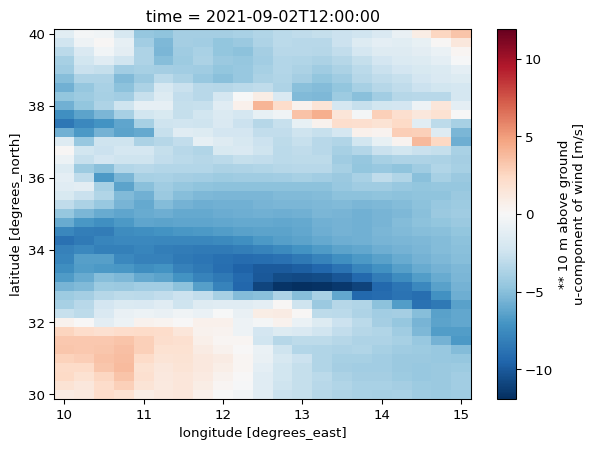

In [4]:
ds.ugrd10m.isel(time=0).plot();

## Convert to dfs2

### Time

In [5]:
time = pd.DatetimeIndex(ds.time)
time

DatetimeIndex(['2021-09-02 12:00:00', '2021-09-02 15:00:00',
               '2021-09-02 18:00:00'],
              dtype='datetime64[ns]', freq=None)

### Variable types

In [6]:
mikeio.EUMType.Air_Pressure

Air Pressure

In [7]:
mikeio.EUMType.Air_Pressure.units

[hectopascal, millibar]

In [8]:
mikeio.EUMType.Wind_Velocity

Wind Velocity

In [9]:
mikeio.EUMType.Wind_Velocity.units

[meter per sec, feet per sec, miles per hour, km per hour, knot]

In [10]:
mslp = ds.msletmsl.values / 100 # conversion from Pa to hPa
u = ds.ugrd10m.values
v = ds.vgrd10m.values

In [11]:
geometry = mikeio.Grid2D(x=ds.lon.values, y=ds.lat.values, projection="LONG/LAT")
geometry

<mikeio.Grid2D>
x: [10, 10.25, ..., 15] (nx=21, dx=0.25)
y: [30, 30.25, ..., 40] (ny=41, dy=0.25)
projection: LONG/LAT

In [12]:
from mikeio import ItemInfo, EUMType, EUMUnit

mslp_da = mikeio.DataArray(data=mslp,time=time, geometry=geometry, item=ItemInfo("Mean Sea Level Pressure", EUMType.Air_Pressure, EUMUnit.hectopascal))
u_da = mikeio.DataArray(data=u,time=time, geometry=geometry, item=ItemInfo("Wind U", EUMType.Wind_Velocity, EUMUnit.meter_per_sec))
v_da = mikeio.DataArray(data=v,time=time, geometry=geometry, item=ItemInfo("Wind V", EUMType.Wind_Velocity, EUMUnit.meter_per_sec))

In [13]:
mds = mikeio.Dataset([mslp_da, u_da, v_da])
mds

<mikeio.Dataset>
dims: (time:3, y:41, x:21)
time: 2021-09-02 12:00:00 - 2021-09-02 18:00:00 (3 records)
geometry: Grid2D (ny=41, nx=21)
items:
  0:  Mean Sea Level Pressure <Air Pressure> (hectopascal)
  1:  Wind U <Wind Velocity> (meter per sec)
  2:  Wind V <Wind Velocity> (meter per sec)

In [14]:
mds.to_dfs("gfs.dfs2")

Clean up

In [15]:
import os

os.remove("gfs.dfs2")